In [3]:
from netCDF4 import Dataset
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
import warnings
import pickle

In [4]:
list_of_pits = pickle.load(open('../data/pit_info.p','rb'))

data_dir = '../data/kuka/required'

In [7]:
def speed(density,form):
    """ Return the radar speed from dry snow density
    density can be in g/cm3 or kg/m3
    form can be 'Ulaby','Hallikainen','Tiuri'
    string can be 'speed', 'factor' or 'wrongfactor'
    """
    c = 3e8
    if density > 10:
        density = density/1000
    speed_dict = {"Ulaby" : c*((1+0.51*density)**(-1.5)),
                  "Hallikainen":c*((1+1.91*density)**(-0.5)),
                  "Tiuri":c*((1+1.7*density + 0.7*density**2)**(-0.5))}
    return(speed_dict[form])

def get_time_ticks(times):
    seconds = [t.second for t in times]
    hours = [t.hour for t in times]
    minutes = [t.minute for t in times]
    time_ticks = [f'{h}:{str(m).zfill(2)}:{str(s).zfill(2)}' for h,m,s in zip(hours, minutes, seconds)]
    return time_ticks
    

def prepare_data(data_dict):
    all_data = {'ku':{},'ka':{}}

    for freq in ['ku','ka']:

        data_list = []
        time_ticks = []
        times = []

        for key, item in data_dict[freq].items():

            data_list.append(item['data'])

            time_ticks += item['time_ticks']
            times += item['times']

        full = np.concatenate(data_list,axis=1)

        all_data[freq] = {'full_data':full,
                          'time_ticks':time_ticks,
                          'times':times,
                         }
    
    return all_data
    
def get_time_index(time,times):
    
    deltas = np.array(times) - time

    secs = np.array([d.seconds for d in deltas])
    ms = np.array([d.microseconds for d in deltas])
    
    secs = secs + (ms * 1e-6)
    
    index = np.argmin(secs)
    
    return index


def get_range_index(input_range,ranges):
    
    deltas = np.array(ranges) - input_range
    
    index = np.argmin(np.abs(deltas))
    
    return index

def prepare_dicts(pit,pol):

    data_dict = {'ku':{},'ka':{}}

    freqranges = {}

    for fnames, freq in zip([pit['ku_f_names'], pit['ka_f_names']],
                            ['ku','ka']):
        for f in fnames:

#             d = Dataset(pit['dir']+'/'+f)

            with Dataset(data_dir+'/'+f) as d:
                data = np.asarray(d[f'{pol}_power_decon0'])
                times = [datetime.datetime(1970,1,1) + datetime.timedelta(seconds=float(s)) for s in d['start_time']]
                ranges = np.asarray(d['range'])
                time_ticks = get_time_ticks(times)

            data_dict[freq][f] = {'data':data,
                            'times':times,
                            'ranges':ranges,
                            'time_ticks':time_ticks}

            freqranges[freq]=ranges
            
    return (freqranges, data_dict)

    
def plot_lines(pit,
               scale='log',
               align_ka_peak=False,
               shift_ka_peak=False,
               xmin=1.3,
               xmax=2.5,
               normalise=False,
               r2_weighting=False,
               plot=True,
               title=True,
               pol='vv'):
    
    freqranges, data_dict = prepare_dicts(pit,pol)
    all_data = prepare_data(data_dict)

    argmaxs = {}
    maxs = {}
    
    return_dict = {}

    for freq in ['ku','ka']:
        
        range_diff=np.nan

        if scale == 'log':
            scan = np.log10(all_data[freq]['full_data'])
        elif scale == 'linear':
            scan = np.array(all_data[freq]['full_data'])
        else:
            raise
        
        time_begin = datetime.datetime.combine(pit['date'], datetime.time(hour=pit[f'{freq}_begin'][0],
                                                minute = pit[f'{freq}_begin'][1],
                                                second = pit[f'{freq}_begin'][2]))

        time_end = datetime.datetime.combine(pit['date'], datetime.time(hour=pit[f'{freq}_end'][0],
                                                minute = pit[f'{freq}_end'][1],
                                                second = pit[f'{freq}_end'][2]))


        start_index = get_time_index(time_begin,
                                     all_data[freq]['times'])
        end_index = get_time_index(time_end,
                                   all_data[freq]['times'])

        scan = scan[:,start_index:end_index]

        y_tick_spacing=7

        line = np.mean(scan,axis=1)

        line[freqranges[freq]<1] = np.nan
        line[freqranges[freq]>3] = np.nan

        if r2_weighting:
            line = np.divide(line,np.square(freqranges[freq]))
            
        argmaxs[freq] = np.nanargmax(line)
        max_power = np.nanmax(line)
        
        if normalise:
            line = line/abs(max_power)
            

        ranges = freqranges[freq]
        
        if align_ka_peak and shift_ka_peak: raise
        
        if align_ka_peak & (freq == 'ka'):
            
            ku_thresh = np.argmax(return_dict['ku_values']>0.1)
            ka_thresh = np.argmax(line>0.1)

            ku_local_maxima = argrelextrema(return_dict['ku_values'], np.greater)[0]
            ka_local_maxima = argrelextrema(line, np.greater)[0]

            ku_nearest_max = return_dict['ku_ranges'][ku_local_maxima[np.argmin(np.abs(ku_local_maxima-ku_thresh))]]
            ka_nearest_max = ranges[ka_local_maxima[np.argmin(np.abs(ka_local_maxima-ka_thresh))]]
            
            range_diff = ka_nearest_max-ku_nearest_max

#             range_diff_old = (freqranges['ka'][argmaxs['ka']]-freqranges['ku'][argmaxs['ku']])
            
            ranges = freqranges[freq] - range_diff
        
        else:
            range_diff = 0
        
        if np.array(shift_ka_peak).any() & (freq == 'ka'):
        
            range_diff = shift_ka_peak
            ranges = freqranges[freq] - range_diff
        
        return_dict[f'{freq}_ranges'] = ranges
        return_dict[f'{freq}_values'] = line
        return_dict[f'{freq}_range_diff'] = range_diff
        
    return return_dict

yticks = list(np.round(np.arange(1,0,-0.2),decimals=1)) + list(np.round(np.arange(0,1.01,0.2),decimals=1))

Day 1, SP 1


/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


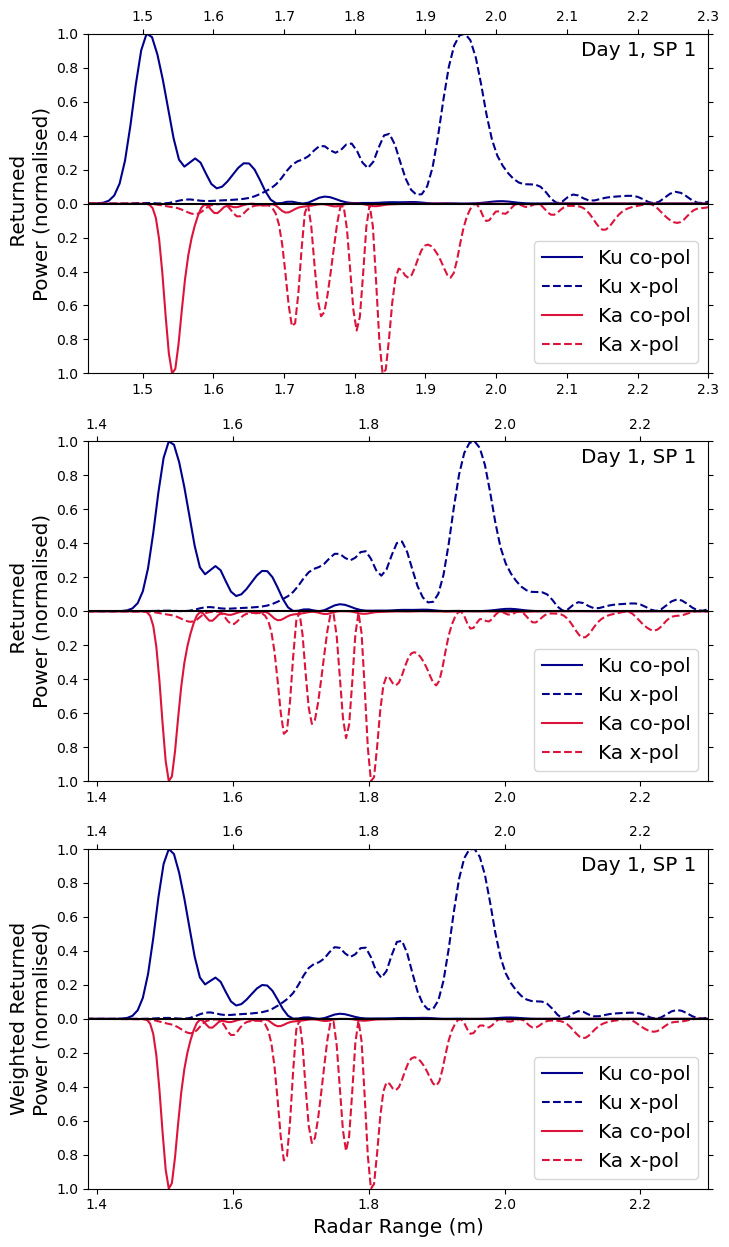

Day 1, SP 2


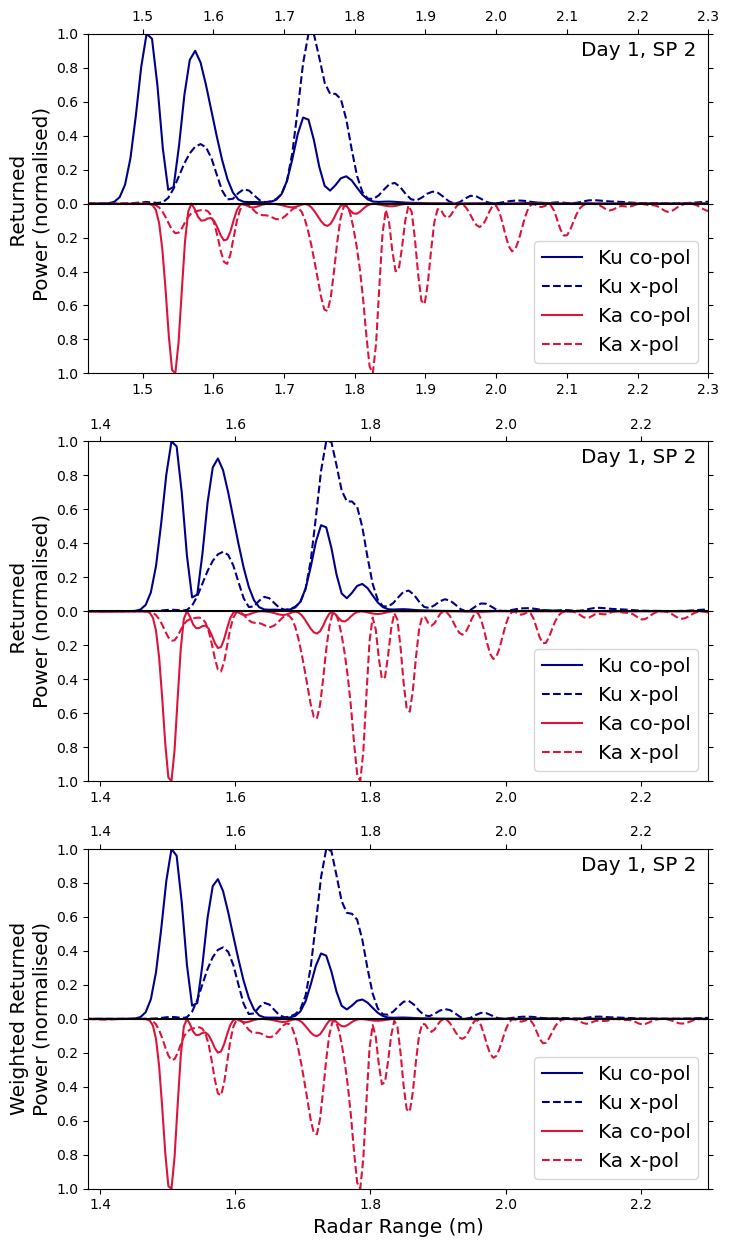

Day 2, SP 1


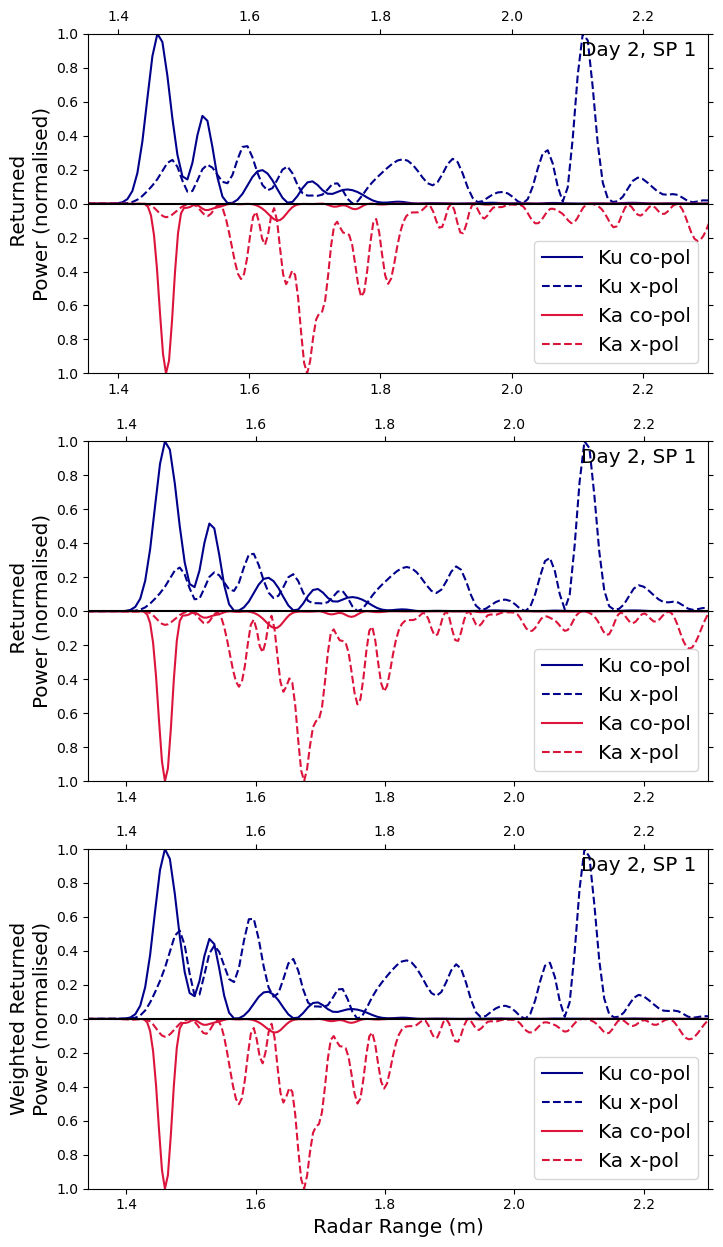

Day 2, SP 2


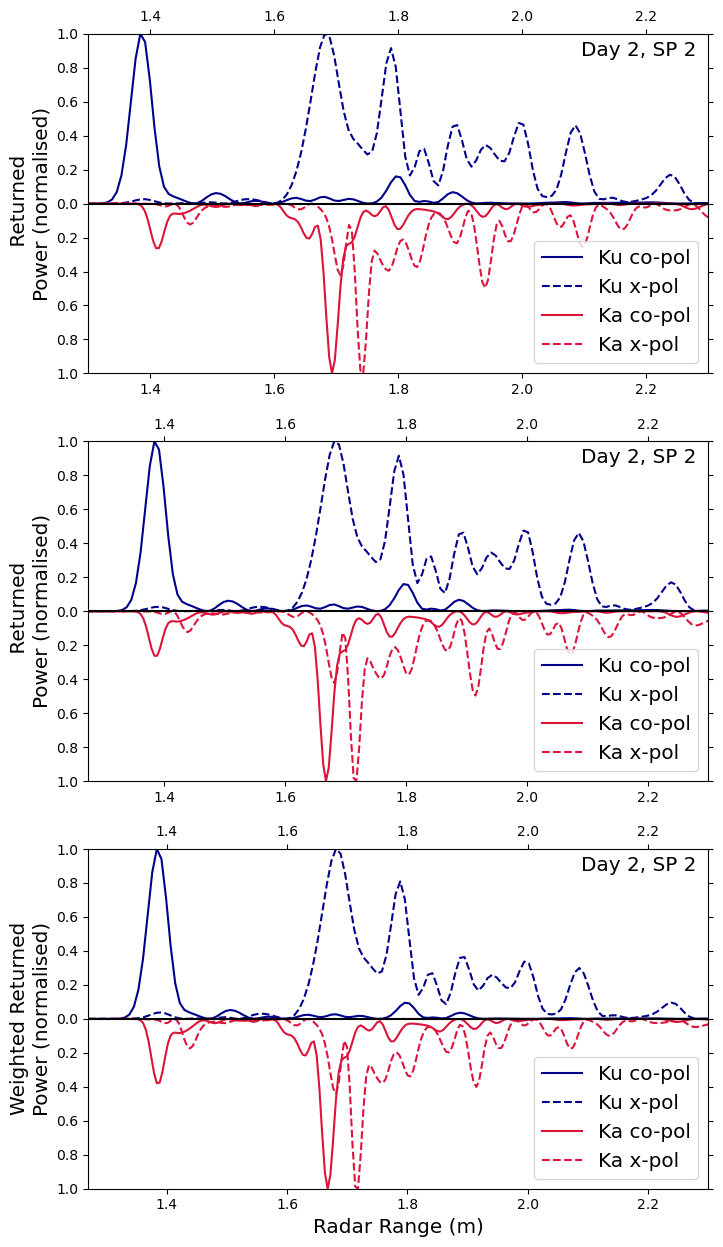

Day 3, SP 1


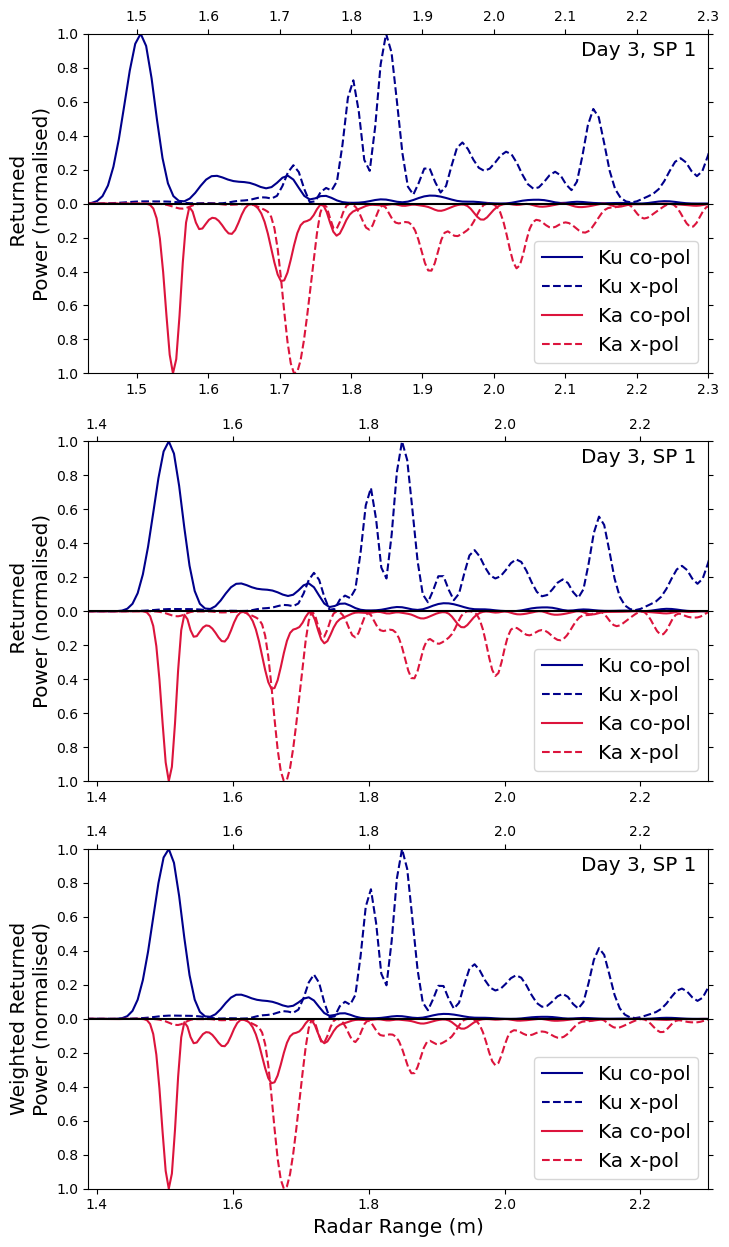

Day 3, SP 2


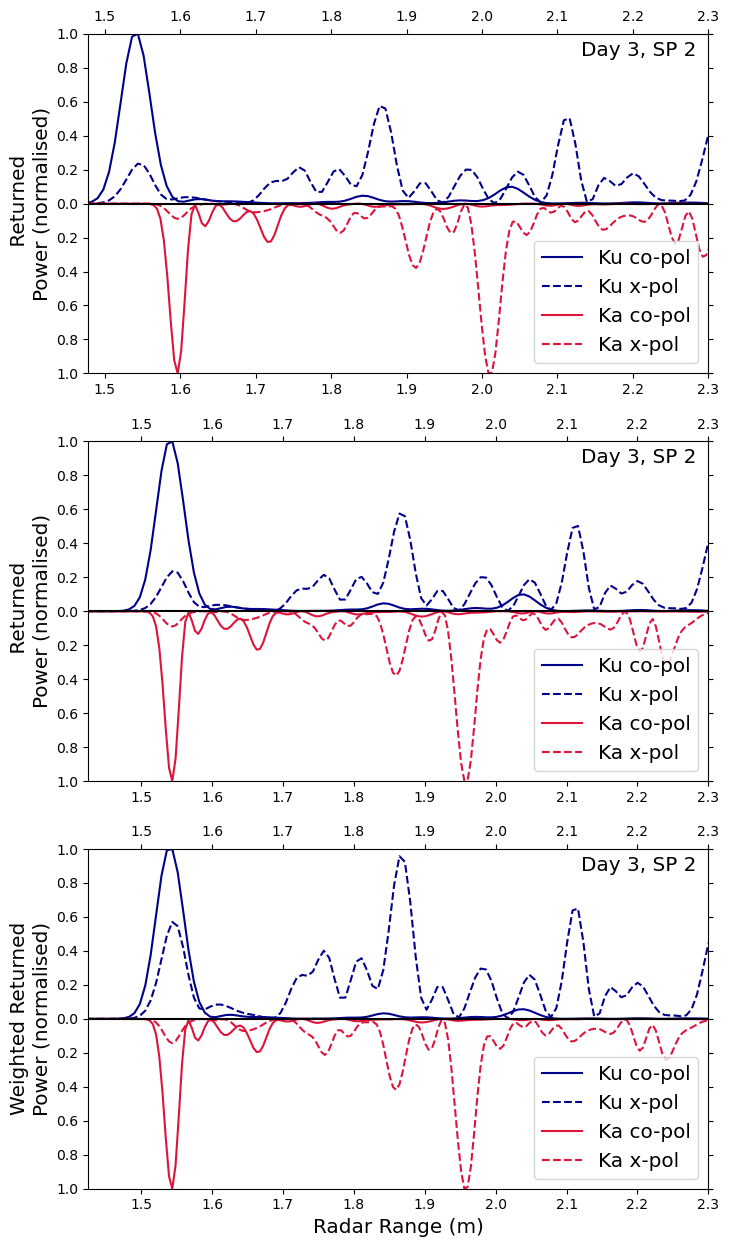

Day 3, SP 3


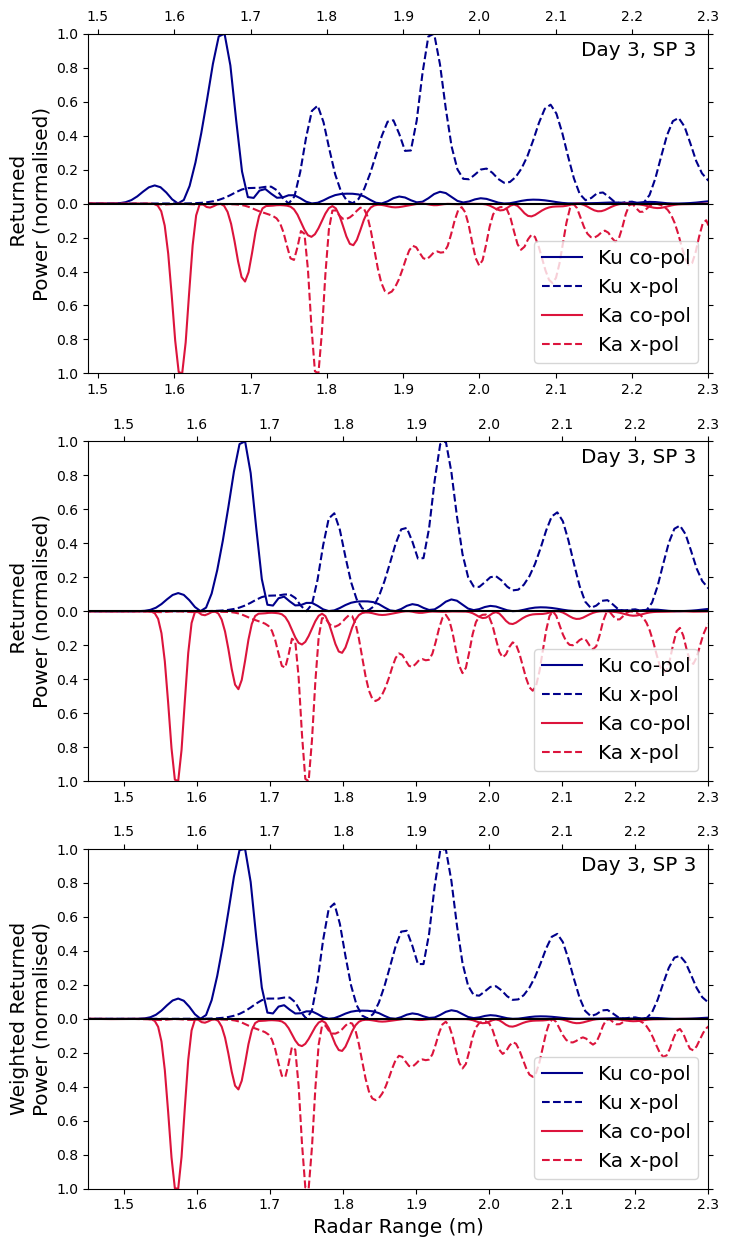

Day 3, SP 4


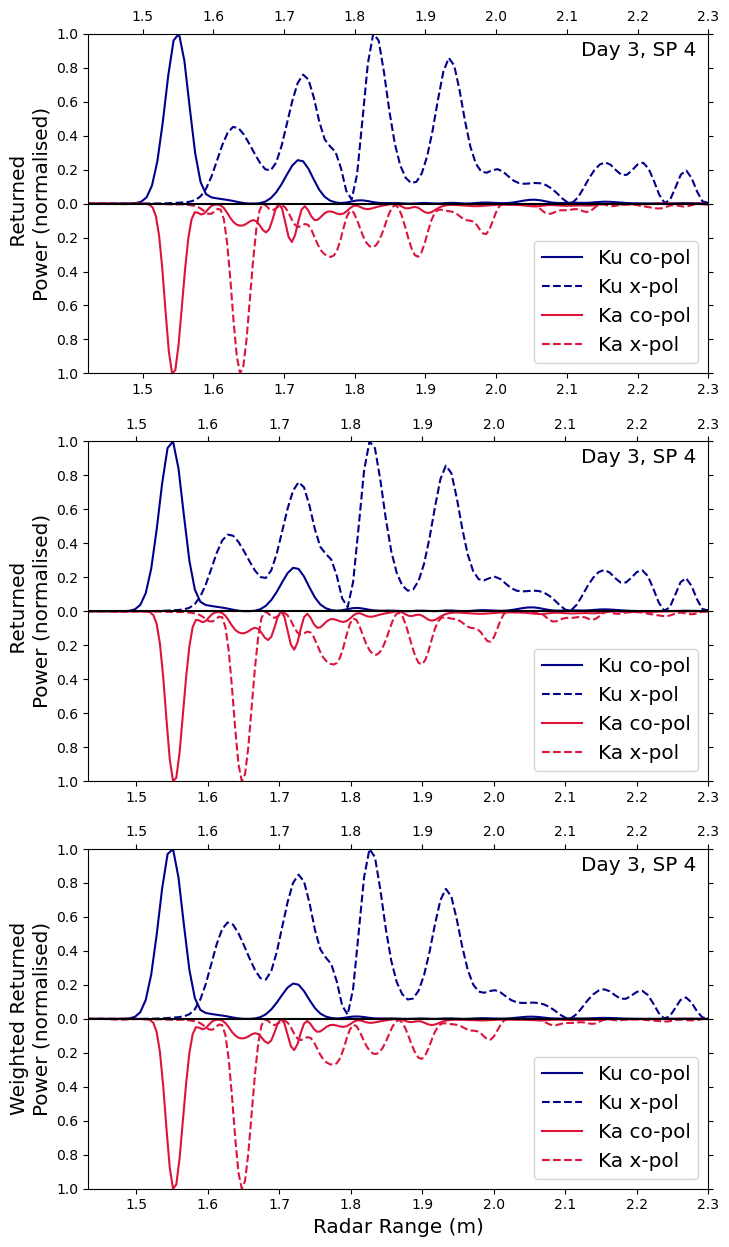

Day 3, SP 5


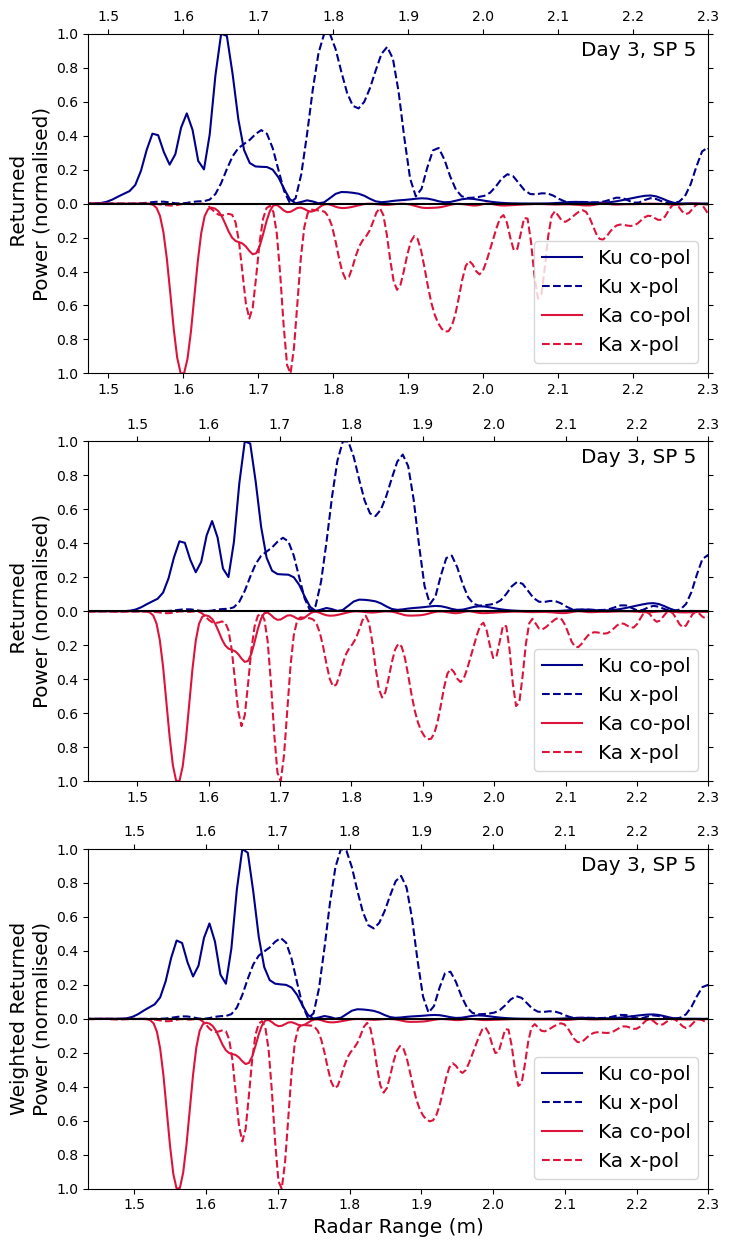

Day 4, SP 1


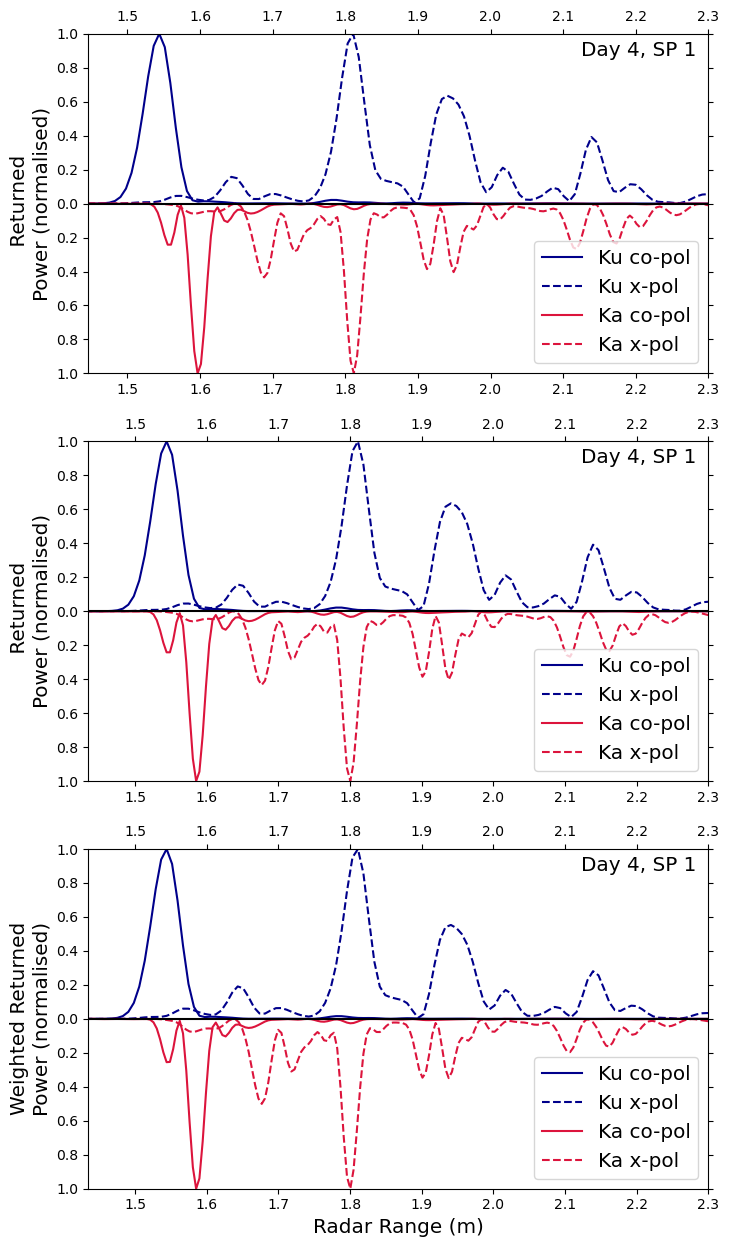

Day 4, SP 2


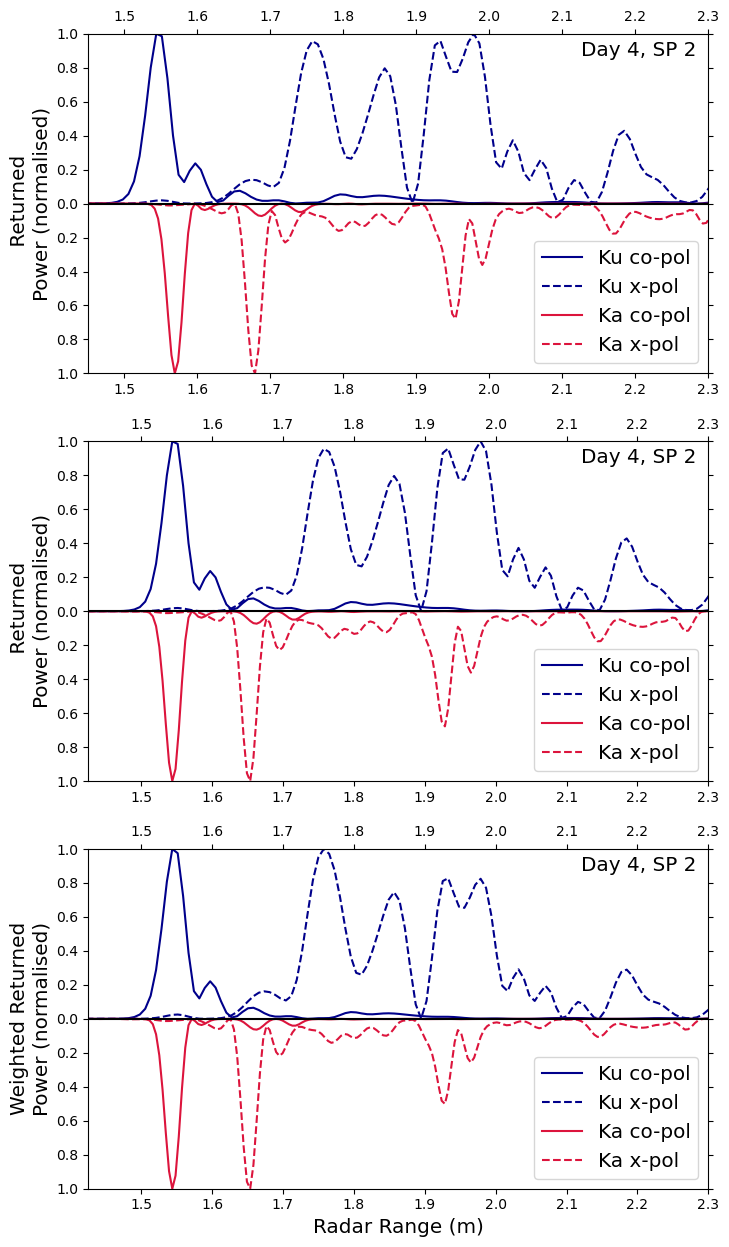

Day 4, SP 3


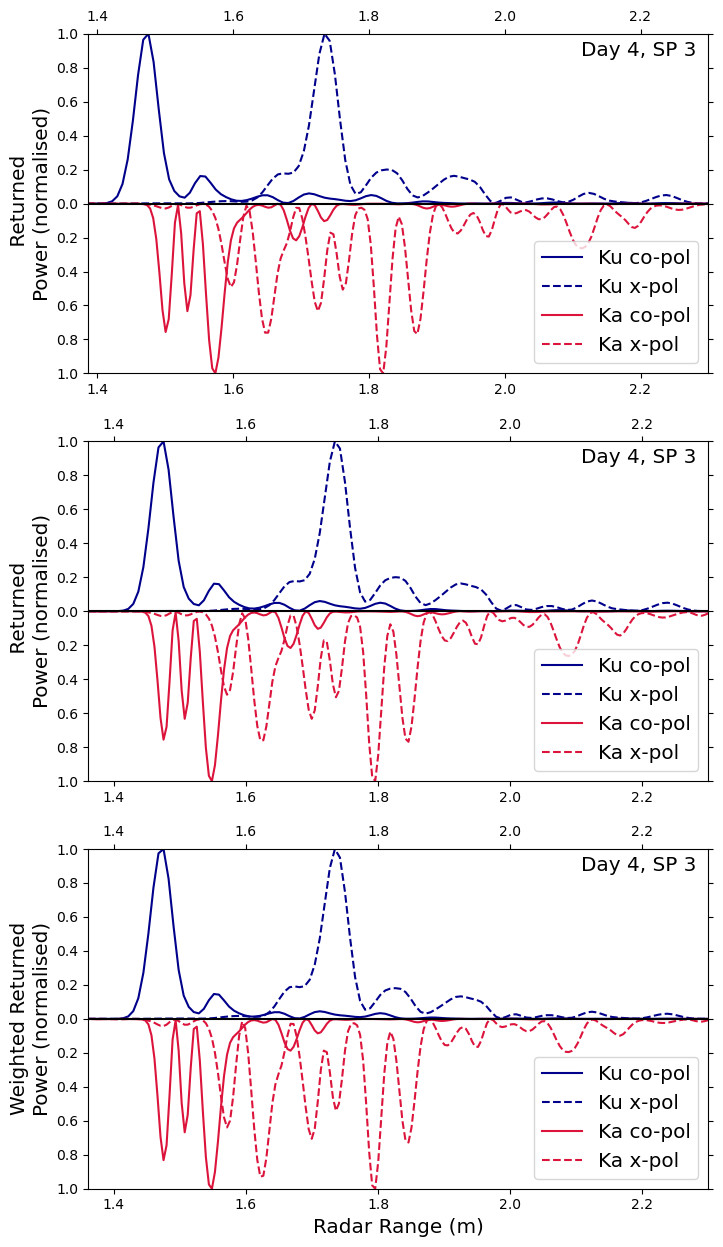

Day 5, SP 1


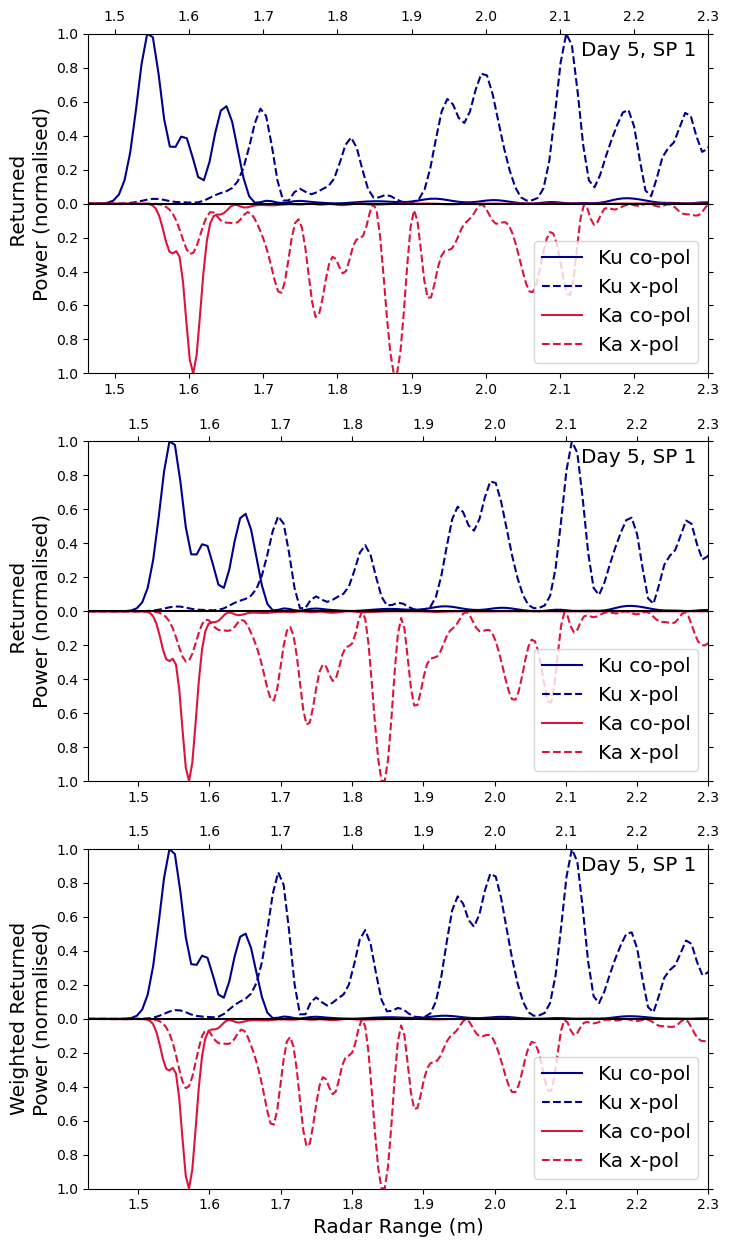

Day 5 SP2 natural


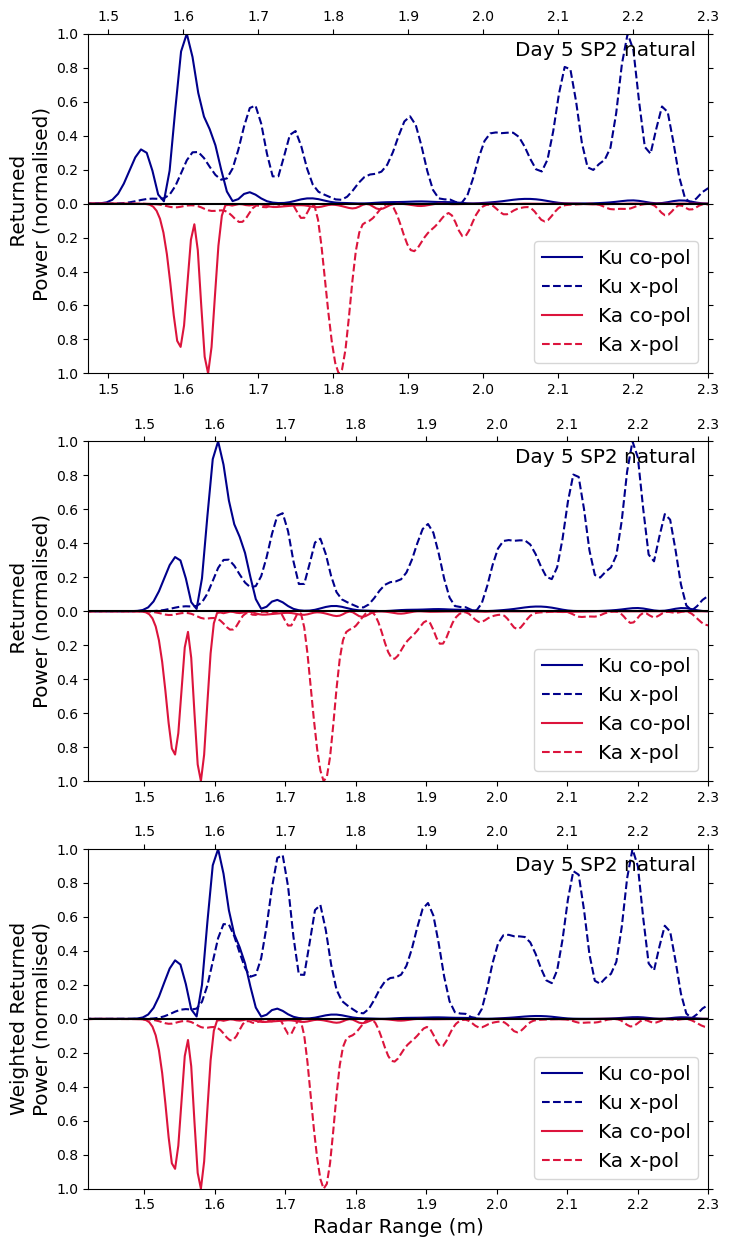

Day 5 SP3


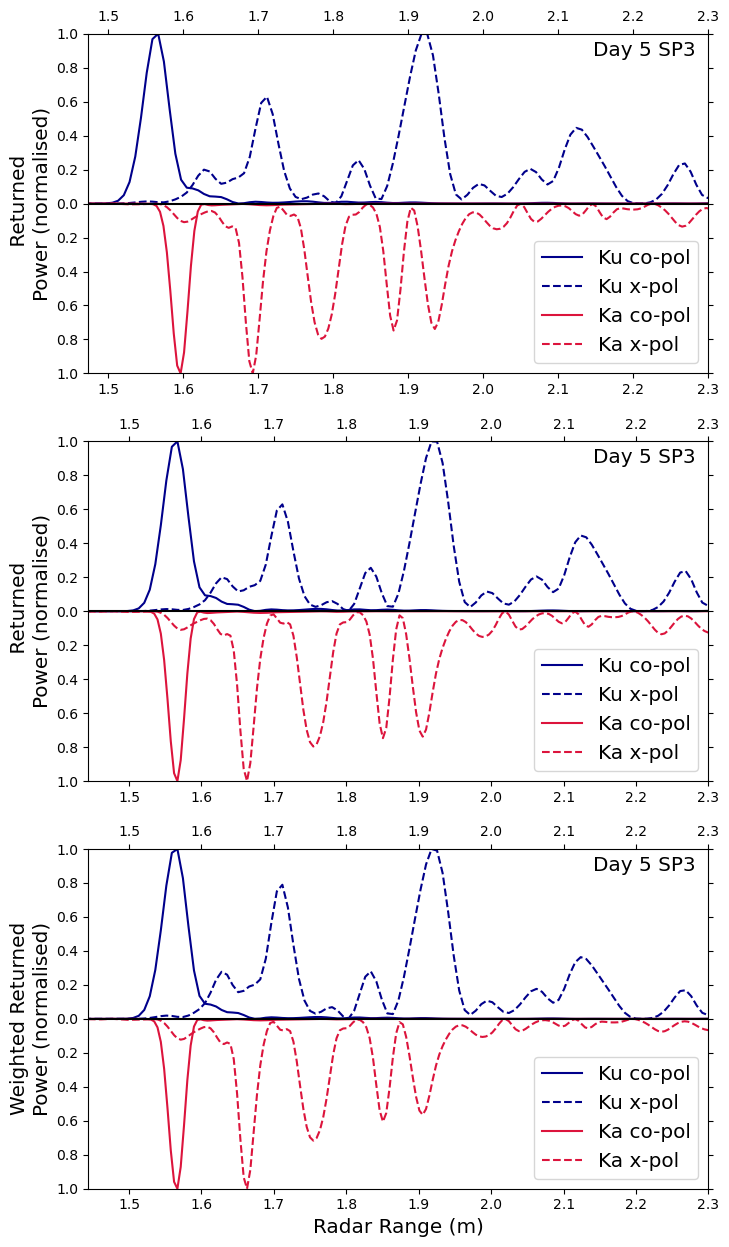

Day 5 SP4


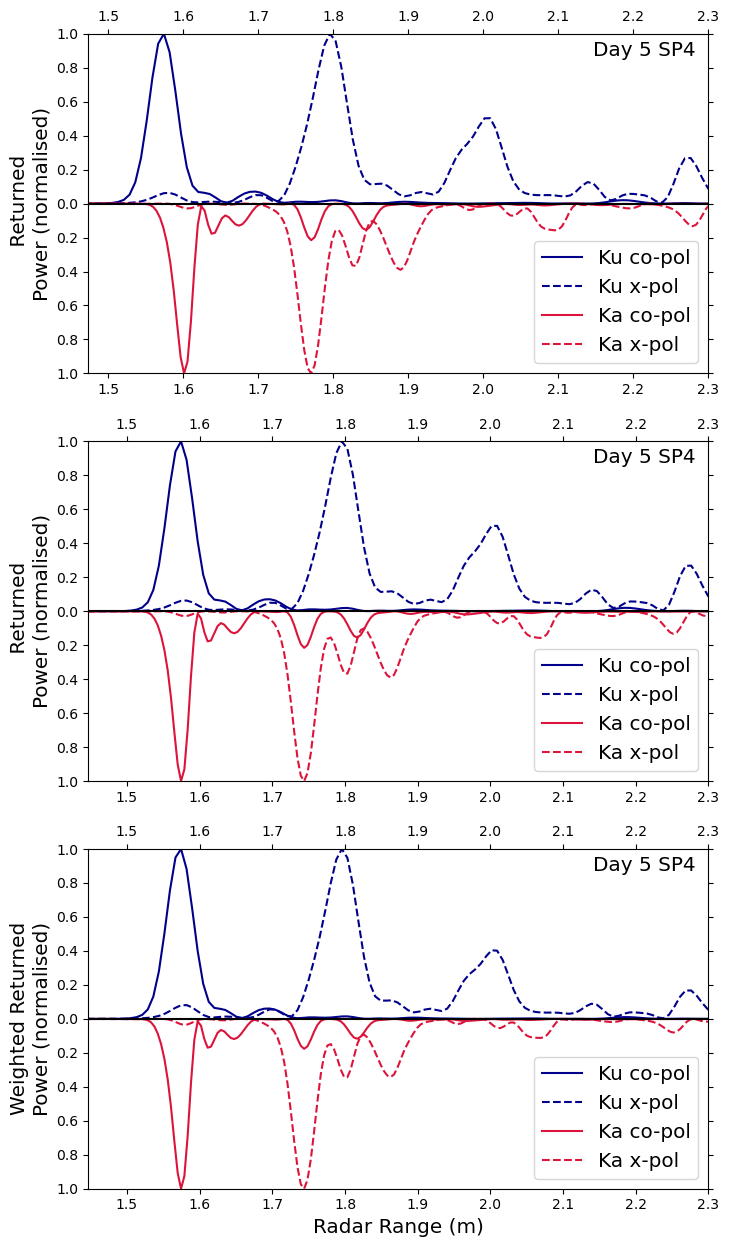

Day 5 SP5


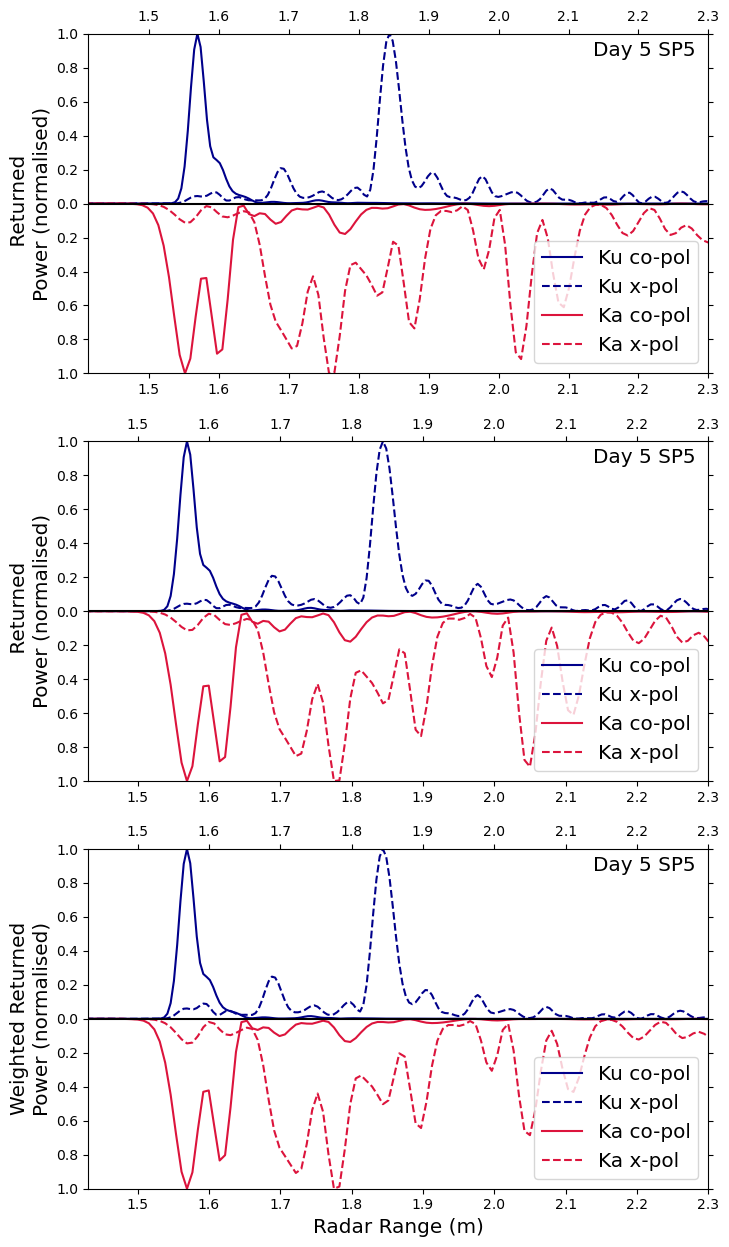

In [8]:
for number,pit in enumerate(list_of_pits):

    fig, axs = plt.subplots(3,1,figsize=(8,15))
    
    r2_weighting = (0,0,1)
    adjust = (0,1,1)
    
    print(pit['name'])
    
    for ax, r2, adjust in zip(axs.reshape(-1),
                              r2_weighting,
                              adjust):

        cp = plot_lines(pit,scale='linear',
                       normalise=True,
                       align_ka_peak=adjust,
                        pol='vv',
                        r2_weighting=r2,
                          )

        xp = plot_lines(pit,scale='linear',
                   normalise=True,
                   shift_ka_peak=cp['ka_range_diff'],
                    pol='vh',
                    r2_weighting=r2,
                      )


        ax.plot(cp['ku_ranges'],cp['ku_values'],color='darkblue',ls='-',label='Ku co-pol')
        ax.plot(xp['ku_ranges'],xp['ku_values'],color='darkblue',ls='--',label='Ku x-pol')

        ax.plot(cp['ka_ranges'],-cp['ka_values'],color='crimson',ls='-',label='Ka co-pol')
        ax.plot(xp['ka_ranges'],-xp['ka_values'],color='crimson',ls='--',label='Ka x-pol')

        ax.set_ylim(-1,1)

        xlim = cp['ka_ranges'][np.argwhere(cp['ka_values']>0.1)[0]]

        ax.set_xlim(xlim-0.1,2.3)

        ax.annotate(pit['name'],xy=(0.98,0.98),
                     va='top',ha='right',
                     fontsize='x-large',
                     xycoords='axes fraction')
        
        yl = 'Weighted' if r2 else ''

        ax.set_ylabel(f'{yl} Returned\nPower (normalised)',fontsize='x-large')
        
        
        if r2: ax.set_xlabel(f'Radar Range (m)',fontsize='x-large')

        ax.set_yticks(np.arange(-1,1.01,0.2))
        ax.set_yticklabels(yticks)    

        ax.legend(loc='lower right',fontsize='x-large')


        ax.xaxis.set_ticks_position('both')
        ax.yaxis.set_ticks_position('both')
        ax.tick_params(labelbottom=True,labeltop=True,labelleft=True)
        ax.axhline(0,color='k')
    
    plt.savefig(f'../figures/composites/{pit["name"]}.jpg')

    plt.show()

# Make plots of the "basic" data

In [ ]:
for number,pit in enumerate(list_of_pits):

    cp = plot_lines(pit,scale='linear',
               normalise=True,
                   pol='vv',plot=False,
                  )
    
    xp = plot_lines(pit,scale='linear',
               normalise=True,
                   pol='vh',
                    plot=False,
                  )


    fig, ax = plt.subplots(1,1,figsize=(8,5))


    ax.plot(cp['ku_ranges'],cp['ku_values'],color='darkblue',ls='-',label='Ku co-pol')
    ax.plot(xp['ku_ranges'],xp['ku_values'],color='darkblue',ls='--',label='Ku x-pol')

    ax.plot(cp['ka_ranges'],-cp['ka_values'],color='crimson',ls='-',label='Ka co-pol')
    ax.plot(xp['ka_ranges'],-xp['ka_values'],color='crimson',ls='--',label='Ka x-pol')

    ax.set_ylim(-1,1)
    
    xlim = cp['ka_ranges'][np.argwhere(cp['ka_values']>0.1)[0]]

    ax.set_xlim(xlim-0.1,2.3)
    ax.set_xlabel('True Radar Range (m)',fontsize='x-large')
        
    ax.annotate(pit['name'],xy=(0.98,0.98),
                 va='top',ha='right',
                 fontsize='x-large',
                 xycoords='axes fraction')
    
    ax.set_ylabel('Returned Power (normalised)',fontsize='x-large')

    ax.set_yticks(np.arange(-1,1.01,0.2))
    ax.set_yticklabels(yticks)    
    
    
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(labelbottom=True,labeltop=True,labelleft=True)
    ax.axhline(0,color='k')

    ax.legend(loc='lower right',fontsize='x-large')
    
#     plt.savefig(f'../figures/true_ranges/{pit["name"]}.jpg',dpi=300)

#     plt.close()
    plt.show()
    
    break

# Now adjust the Ka-band data to match the ku-band data

In [ ]:
for number,pit in enumerate(list_of_pits):

    cp = plot_lines(pit,scale='linear',
               normalise=True,
               align_ka_peak=True,
                pol='vv',
                plot=False,
                  )
    
    xp = plot_lines(pit,scale='linear',
               normalise=True,
               shift_ka_peak=cp['ka_range_diff'],
                pol='vh',
                plot=False,
                  )

    fig, ax = plt.subplots(1,1,figsize=(8,5))

    ax.plot(cp['ku_ranges'],cp['ku_values'],color='darkblue',ls='-',label='Ku co-pol')
    ax.plot(xp['ku_ranges'],xp['ku_values'],color='darkblue',ls='--',label='Ku x-pol')

    ax.plot(cp['ka_ranges'],-cp['ka_values'],color='crimson',ls='-',label='Ka co-pol')
    ax.plot(xp['ka_ranges'],-xp['ka_values'],color='crimson',ls='--',label='Ka x-pol')

    ax.set_ylim(-1,1)
    
    xlim = cp['ka_ranges'][np.argwhere(cp['ka_values']>0.1)[0]]

    ax.set_xlim(xlim-0.1,2.3)
    ax.set_xlabel('Adjusted Radar Range (m)',fontsize='x-large')
        
    ax.annotate(pit['name'],xy=(0.98,0.98),
                 va='top',ha='right',
                 fontsize='x-large',
                 xycoords='axes fraction')
    
    ax.set_ylabel('Returned Power (normalised)',fontsize='x-large')

    ax.set_yticks(np.arange(-1,1.01,0.2))
    ax.set_yticklabels(yticks)    

    
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(labelbottom=True,labeltop=True,labelleft=True)
    ax.axhline(0,color='k')
    
    ax.legend(loc='lower right',fontsize='x-large')

#     plt.savefig(f'../figures/aligned_ranges/{pit["name"]}.jpg',dpi=300)
    
#     plt.close()
    
    plt.show()
    
#     break

# Now perform the inverse square weighting

In [ ]:
for number,pit in enumerate(list_of_pits):

    cp = plot_lines(pit,scale='linear',
               normalise=True,
               align_ka_peak=True,
                pol='vv',
                r2_weighting=True,
                plot=False,
                  )
    
    xp = plot_lines(pit,scale='linear',
               normalise=True,
               shift_ka_peak=cp['ka_range_diff'],
                pol='vh',
            r2_weighting=True,
                plot=False,
                  )


    fig, ax = plt.subplots(1,1,figsize=(8,5))

    ax.plot(cp['ku_ranges'],cp['ku_values'],color='darkblue',ls='-',label='Ku co-pol')
    ax.plot(xp['ku_ranges'],xp['ku_values'],color='darkblue',ls='--',label='Ku x-pol')

    ax.plot(cp['ka_ranges'],-cp['ka_values'],color='crimson',ls='-',label='Ka co-pol')
    ax.plot(xp['ka_ranges'],-xp['ka_values'],color='crimson',ls='--',label='Ka x-pol')

    ax.set_ylim(-1,1)
    
    xlim = cp['ka_ranges'][np.argwhere(cp['ka_values']>0.1)[0]]

    ax.set_xlim(xlim-0.1,2.3)
    ax.set_xlabel('Adjusted Radar Range (m)',fontsize='x-large')
        
    ax.annotate(pit['name'],xy=(0.98,0.98),
                 va='top',ha='right',
                 fontsize='x-large',
                 xycoords='axes fraction')
    
    ax.set_ylabel('Weighted Returned Power (normalised)',fontsize='x-large')

    ax.set_yticks(np.arange(-1,1.01,0.2))
    ax.set_yticklabels(yticks)    

    ax.legend(loc='lower right',fontsize='x-large')

    
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(labelbottom=True,labeltop=True,labelleft=True)
    ax.axhline(0,color='k')
    
    plt.savefig(f'../figures/r2_weighting/{pit["name"]}.jpg',dpi=300,bbox_inches='tight')

    plt.close()